In [1]:
import pandas as pd

csv_path = '/Users/nikolaymachev/Downloads/Melanoma_Project_Data/HAM10000_metadata.csv'

df = pd.read_csv(csv_path)

# Create binary label column
df['label'] = df['dx'].apply(lambda x: 1 if x == 'mel' else 0)

# Use the entire dataset
final_df = df.copy()

print("✅ Loaded all rows:", final_df.shape[0])
print(final_df['label'].value_counts())


✅ Loaded all rows: 10015
label
0    8902
1    1113
Name: count, dtype: int64


In [3]:
import os
import shutil

images_dir = '/Users/nikolaymachev/Downloads/Melanoma_Project_Data/HAM10000_images'

# Define output folders
output_dir = '/Users/nikolaymachev/Downloads/Melanoma_Project_Data/data'
mel_dir = os.path.join(output_dir, 'melanoma')
nonmel_dir = os.path.join(output_dir, 'non_melanoma')

# Create output folders if they don't exist
os.makedirs(mel_dir, exist_ok=True)
os.makedirs(nonmel_dir, exist_ok=True)

copied_count = 0
missing_count = 0

for _, row in final_df.iterrows():
    image_id = row['image_id']
    label = row['label']
    
    src = os.path.join(images_dir, image_id + '.jpg')
    
    if os.path.exists(src):
        dst_dir = mel_dir if label == 1 else nonmel_dir
        dst = os.path.join(dst_dir, image_id + '.jpg')
        shutil.copyfile(src, dst)
        copied_count += 1
    else:
        print(f"Image {image_id}.jpg not found in HAM10000_images.")
        missing_count += 1

print(f"✅ Copy complete. Total copied: {copied_count}, Missing: {missing_count}")


✅ Copy complete. Total copied: 10015, Missing: 0


In [4]:
mel_dir = '/Users/nikolaymachev/Downloads/Melanoma_Project_Data/data/melanoma'
nonmel_dir = '/Users/nikolaymachev/Downloads/Melanoma_Project_Data/data/non_melanoma'

mel_count = len(os.listdir(mel_dir))
nonmel_count = len(os.listdir(nonmel_dir))

print("Melanoma images:", mel_count)
print("Non-melanoma images:", nonmel_count)
print("Total images:", mel_count + nonmel_count)


Melanoma images: 1113
Non-melanoma images: 8902
Total images: 10015


In [5]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os


/Users/nikolaymachev/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [6]:
# Advanced data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_gen = datagen.flow_from_directory(
    '/Users/nikolaymachev/Downloads/Melanoma_Project_Data/data',
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    '/Users/nikolaymachev/Downloads/Melanoma_Project_Data/data',
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 8013 images belonging to 2 classes.
Found 2002 images belonging to 2 classes.


In [8]:
pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.1 MB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 307 kB 28.5 MB/s eta 0:00:01
     |████████████████████████████████| 30.3 MB 4.6 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [9]:
from sklearn.utils import class_weight
import numpy as np

# Get class indices from the generator
train_labels = train_gen.classes

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights_dict = dict(enumerate(class_weights))
print("✅ Computed class weights:", class_weights_dict)


✅ Computed class weights: {0: np.float64(4.4966329966329965), 1: np.float64(0.5625526537489469)}


In [10]:
print(train_gen.class_indices)


{'melanoma': 0, 'non_melanoma': 1}


In [12]:
# Load EfficientNetB3 backbone
base_model = EfficientNetB3(
    include_top=False,
    weights='imagenet',
    input_tensor=Input(shape=(300, 300, 3))
)

# Unfreeze the entire model for fine-tuning
base_model.trainable = True

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()
print("✅ EfficientNetB3 model built and compiled.")



43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 11,177,264 (42.64 MB)

 Trainable params: 11,089,961 (42.30 MB)

 Non-trainable params: 87,303 (341.03 KB)

✅ EfficientNetB3 model built and compiled.


In [13]:
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    class_weight=class_weights_dict
)


/Users/nikolaymachev/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 3548s 14s/step - accuracy: 0.5296 - loss: 0.7009 - val_accuracy: 0.1628 - val_loss: 0.7610
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 2454s 10s/step - accuracy: 0.5960 - loss: 0.6328 - val_accuracy: 0.8701 - val_loss: 0.5027
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 2536s 10s/step - accuracy: 0.6384 - loss: 0.5733 - val_accuracy: 0.7962 - val_loss: 0.3973
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 2471s 10s/step - accuracy: 0.6458 - loss: 0.5292 - val_accuracy: 0.8197 - val_loss: 0.3629
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 4618s 15s/step - accuracy: 0.6687 - loss: 0.5061 - val_accuracy: 0.8252 - val_loss: 0.3459
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 2314s 9s/step - accuracy: 0.7007 - loss: 0.4733 - val_accuracy: 0.8417 - val_loss: 0.3451
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 2524s 10s/step - accuracy: 0.7166 - loss: 0.4661 - val_accuracy: 0.8472 - val_loss: 0.3260
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 2824s 11s/step - accuracy: 0.7265 - loss: 0.

In [14]:
model.save('/Users/nikolaymachev/Downloads/Melanoma_Project_Data/efficientnet_model.h5')
print("✅ Model saved.")

✅ Model saved.


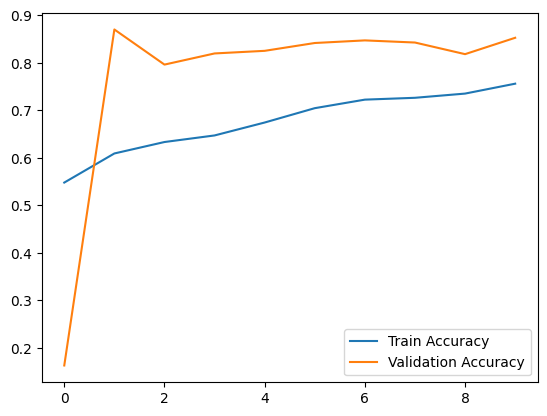

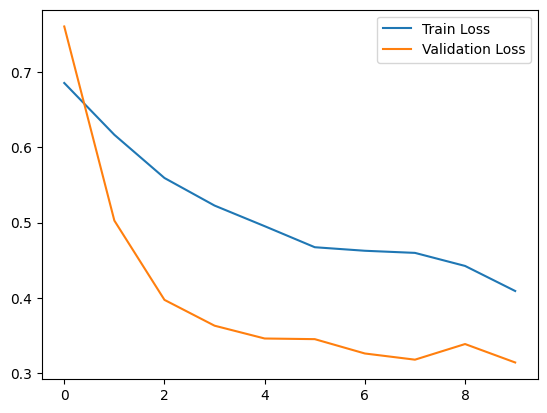

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [16]:
import tensorflow as tf

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

# Evaluate on validation data
results = model.evaluate(val_gen)
print(dict(zip(model.metrics_names, results)))

63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.8339 - auc: 0.8487 - loss: 0.3387 - precision: 0.9372 - recall: 0.8700
{'loss': 0.3303454518318176, 'compile_metrics': 0.8371628522872925}


In [17]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

print("✅ Model recompiled with lower learning rate for fine-tuning.")


✅ Model recompiled with lower learning rate for fine-tuning.


In [18]:
fine_tune_history = model.fit(
    train_gen,
    epochs=3,             # fine-tune for 3 additional epochs
    validation_data=val_gen,
    class_weight=class_weights_dict
)

Epoch 1/3
251/251 ━━━━━━━━━━━━━━━━━━━━ 9363s 37s/step - accuracy: 0.7670 - auc: 0.8811 - loss: 0.4263 - precision: 0.9688 - recall: 0.7614 - val_accuracy: 0.8437 - val_auc: 0.8694 - val_loss: 0.3192 - val_precision: 0.9475 - val_recall: 0.8725
Epoch 2/3
251/251 ━━━━━━━━━━━━━━━━━━━━ 2034s 8s/step - accuracy: 0.7731 - auc: 0.8930 - loss: 0.3982 - precision: 0.9737 - recall: 0.7657 - val_accuracy: 0.8312 - val_auc: 0.8626 - val_loss: 0.3541 - val_precision: 0.9467 - val_recall: 0.8584
Epoch 3/3
251/251 ━━━━━━━━━━━━━━━━━━━━ 2119s 8s/step - accuracy: 0.7744 - auc: 0.8902 - loss: 0.3944 - precision: 0.9799 - recall: 0.7638 - val_accuracy: 0.7243 - val_auc: 0.8880 - val_loss: 0.5023 - val_precision: 0.9804 - val_recall: 0.7039


In [19]:
model.save('/Users/nikolaymachev/Downloads/Melanoma_Project_Data/efficientnet_model_finetuned.h5')
print("✅ Fine-tuned model saved.")

✅ Fine-tuned model saved.


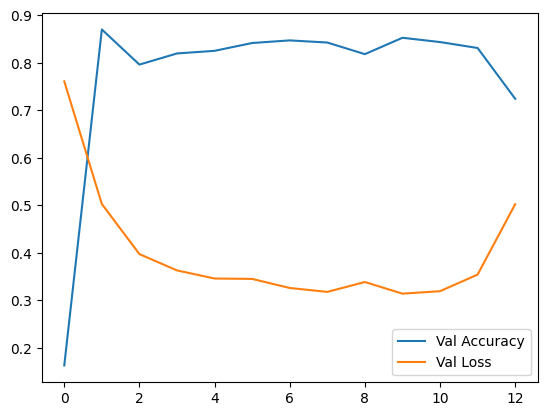

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['val_loss'] + fine_tune_history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()